In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

## People Analysis (to poach list)

In [3]:
plt.style.use('seaborn-talk')

In [4]:
namekey = pd.read_csv('cleanData/cleanIMDB/imdb_namekey.csv', index_col=0) # import name key

In [5]:
comp = pd.read_csv('cleanData/imdb_combined_prof.csv') # import movie composite dataset - info and ROI % info

In [6]:
# remove unnecessary columns
comp.drop(axis=1, labels=['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y', 'id', 'concat'], inplace=True)

## Step 1: Prepare dataframe for grouping

In [7]:
# if possible, convert list-looking strings into actual lists for downstream df.explode()
def lit_try(val):
    try:
        return literal_eval(val) # function which parses strings to find type
    except:
        return val # pass null values or other non-strings to avoid exceptions

In [8]:
comp.iloc[:,8:22] = comp.iloc[:,8:22].applymap(lit_try) # convert role column values into lists

In [9]:
# add two director columns together (columns from two different sources)
comp['director'] = comp['directors'] + comp['director_pr']

In [10]:
# add two writer columns together (columns from two different sources)
comp['writer'] = comp['writers'] + comp['writer_pr']

In [11]:
# add actor and actress columns to make gender neutral column
comp['actor/actress'] = comp['actor'] + comp['actress']

### Select most important roles

Of all the available roles, let's select all but the production designer, archive footage, archive sound, and self

In [12]:
# list of roles we want to analyze
pplorder = ['actor','actress','actor/actress','director','writer','producer','cinematographer','editor','composer']

## Step 2: Group movies by person, for each role

Because the process to analyze the data is so similar across the various roles we're interested in, I'm going to write a loop that does all the analyses iteratively for each role `ppl` (people) in `pplorder`.

This will use two dictionaries:

1. `ppldfdictpre` has key `ppl` for each item in `pplorder`, for value dataframe which results from the original `comp` composite dataframe exploded on the column named `ppl`. This will be used for downstream calculation of the career ROI% for each person, done by using the sums of the worldwide gross and budget numbers for all the movies each person has worked on, `ROI_careertot%`. This will also be used to get the number of movies each person (in role `ppl`) worked on, `movie_count`.
2. `ppldfdict` has key `ppl` for each item in `pplorder`, for value dataframe which results from the original `comp` composite dataframe, grouped by individual person id value (`nconst` in `namekey` dataframe) in column `ppl`, and the means for all the numerical columns of these groups. The resulting dataframe is trimmed to only include necessary columns for downstream analysis: `start_year`, `runtime_minutes`, `averagerating`, `numvotes`, `worldwide_gross_inf`, `production_budget_inf`, `ROI_careertot%`, and `movie_count`.

In [13]:
# create dictionaries to store a dataframe (value) for each role (key)
ppldfdictpre = {} # initialize dictionary for explode/drop_duplicates step
ppldfdict = {}    # initialize dictionary to store end result

for ppl in pplorder: # loop over each role (`ppl`) in `pplorder`
    
    # for each role (`ppl`):

    # explode lists present in the column named `ppl` in composite dataframe (`comp`)
    # drop the duplicates ("director" & "writer" in particular was expected to have dupes)
        # (duplicates found by subset to avoid list error with other `ppl` columns in `comp`)
    # store the resulting dataframe as a value with key `ppl` in `ppldfdictpre` dictionary
    ppldfdictpre[ppl] = comp.explode(ppl).drop_duplicates(subset=['tconst','primary_title','start_year',ppl])
    
    # for key `ppl` in `ppldfdictpre` dictionary, take the value dataframe
    # group the `ppl` column by name id value (`nconst` in `namekey` dataframe)
    # take the mean of the aggregated groups' numerical columns
    # store the resulting dataframe as a value with key `ppl` in `ppldfdict` dictionary
    ppldfdict[ppl] = ppldfdictpre[ppl].groupby(ppl).mean()
    
    # for key `ppl` in `ppldfdictpre` dictionary, take the value dataframe
    # group the `ppl` column by name id value (`nconst` in `namekey` dataframe)
    # take the sum of the aggregated groups' numerical columns
    # do series math: 
        # use those summed columns to calculate ROI% with `worldwide_gross_inf` and `production_budget_inf`
    # store the resulting series as column `ROI_careertot%` in `ppldfdict[ppl]`
    ppldfdict[ppl]['ROI_careertot%'] = (ppldfdictpre[ppl].groupby(ppl).sum()['worldwide_gross_inf'] -\
                                     ppldfdictpre[ppl].groupby(ppl).sum()['production_budget_inf']) /\
                                     ppldfdictpre[ppl].groupby(ppl).sum()['production_budget_inf']*100
    
    # for key `ppl` in `ppldfdictpre` dictionary, take the value dataframe
    # group the `ppl` column by name id value (`nconst` in `namekey` dataframe)
    # get the number of rows per aggregated group with .size()
    ppldfdict[ppl]['movie_count'] = ppldfdictpre[ppl].groupby(ppl).size()
    
    # for key `ppl` in `ppldfdict` dictionary, sort by `ROI_careertot%` descending
    ppldfdict[ppl]= ppldfdict[ppl].sort_values(by='ROI_careertot%',ascending=False)
    
    # for key `ppl` in `ppldfdict` dictionary, trim columns to only what we need downstream
    ppldfdict[ppl] = ppldfdict[ppl][['start_year','runtime_minutes','averagerating','numvotes','worldwide_gross_inf',\
                                     'production_budget_inf','ROI_careertot%','movie_count']]

## Step 3: Merge with name info

Now we'll use the `namekey` dataframe to yield the name info for each `nconst` value in the `ppl` role dataframes.

In [14]:
# merge the role dataframes with the name info
ppl_comp = {} # dictionary for composite people dataframes
ppl_nums = {} # dictionary for counts of each dataframe
for ppl in ppldfdict.keys():
    ppl_comp[ppl] = ppldfdict[ppl].merge(namekey, how='left', left_on=ppl, right_on='nconst')
    ppl_nums[ppl] = len(ppl_comp[ppl]) # number of people in each role

## Step 4: Filter dataframes for people with 2+ and 3+ movies worked on

Because people might only have one successful movie to their name, aka 'one-hit wonders', let's filter the original dataset for at least 2 and at least 3 movies. At least 3 movies was done for exploratory purposes, but is ultimately deemed extraneous. I have kept it here anyways.

Create 2 new pairs of dictionaries:
1. `ppl_comp2` and `ppl2_nums`
2. `ppl_comp3` and `ppl3_nums`

In [15]:
# removing people with only one movie to their name - 'one-hit wonders'
# people with movie_count >= 2
ppl_comp2 = {}
ppl2_nums = {}
for ppl in ppl_comp.keys():
    ppl_comp2[ppl] = ppl_comp[ppl][ppl_comp[ppl]['movie_count'] >= 2]
    ppl2_nums[ppl] = len(ppl_comp2[ppl]) # number of people in each role

In [16]:
# people with movie_count >= 3
ppl_comp3 = {}
ppl3_nums = {}
for ppl in ppl_comp.keys():
    ppl_comp3[ppl] = ppl_comp[ppl][ppl_comp[ppl]['movie_count'] >= 3]
    ppl3_nums[ppl] = len(ppl_comp3[ppl]) # number of people in each role

## Step 5: Find average movie counts and %ROI for each dataframe in all three dictionaries
Create 3 new dictionaries:
1. `ppl_comp_avgs`
2. `ppl_comp2_avgs`
3. `ppl_comp3_avgs`

In [17]:
ppl_comp_avgs = {}
for ppl in ppl_comp.keys():
    ppl_comp_avgs[f'{ppl}_movie_count'] = ppl_comp[ppl]['movie_count'].mean()
    ppl_comp_avgs[f'{ppl}_%ROI_avg'] = ppl_comp[ppl]['ROI_careertot%'].mean()

In [18]:
ppl_comp2_avgs = {}
for ppl in ppl_comp2.keys():
    ppl_comp2_avgs[f'{ppl}_movie_count'] = ppl_comp2[ppl]['movie_count'].mean()
    ppl_comp2_avgs[f'{ppl}_%ROI_avg'] = ppl_comp2[ppl]['ROI_careertot%'].mean()

In [19]:
ppl_comp3_avgs = {}
for ppl in ppl_comp3.keys():
    ppl_comp3_avgs[f'{ppl}_movie_count'] = ppl_comp3[ppl]['movie_count'].mean()
    ppl_comp3_avgs[f'{ppl}_%ROI_avg'] = ppl_comp3[ppl]['ROI_careertot%'].mean()

## Step 6: Visualize # of Movies vs. %ROI for each role using a scatterplot

\# of movies is used a proxy for consistent success in people's various roles. For example, one movie might just be a fluke, aka "One Hit Wonder" status.

Because all the dataframes are stored as dictionaries, it will be easy to iterate through them to quickly make a collection of figures.

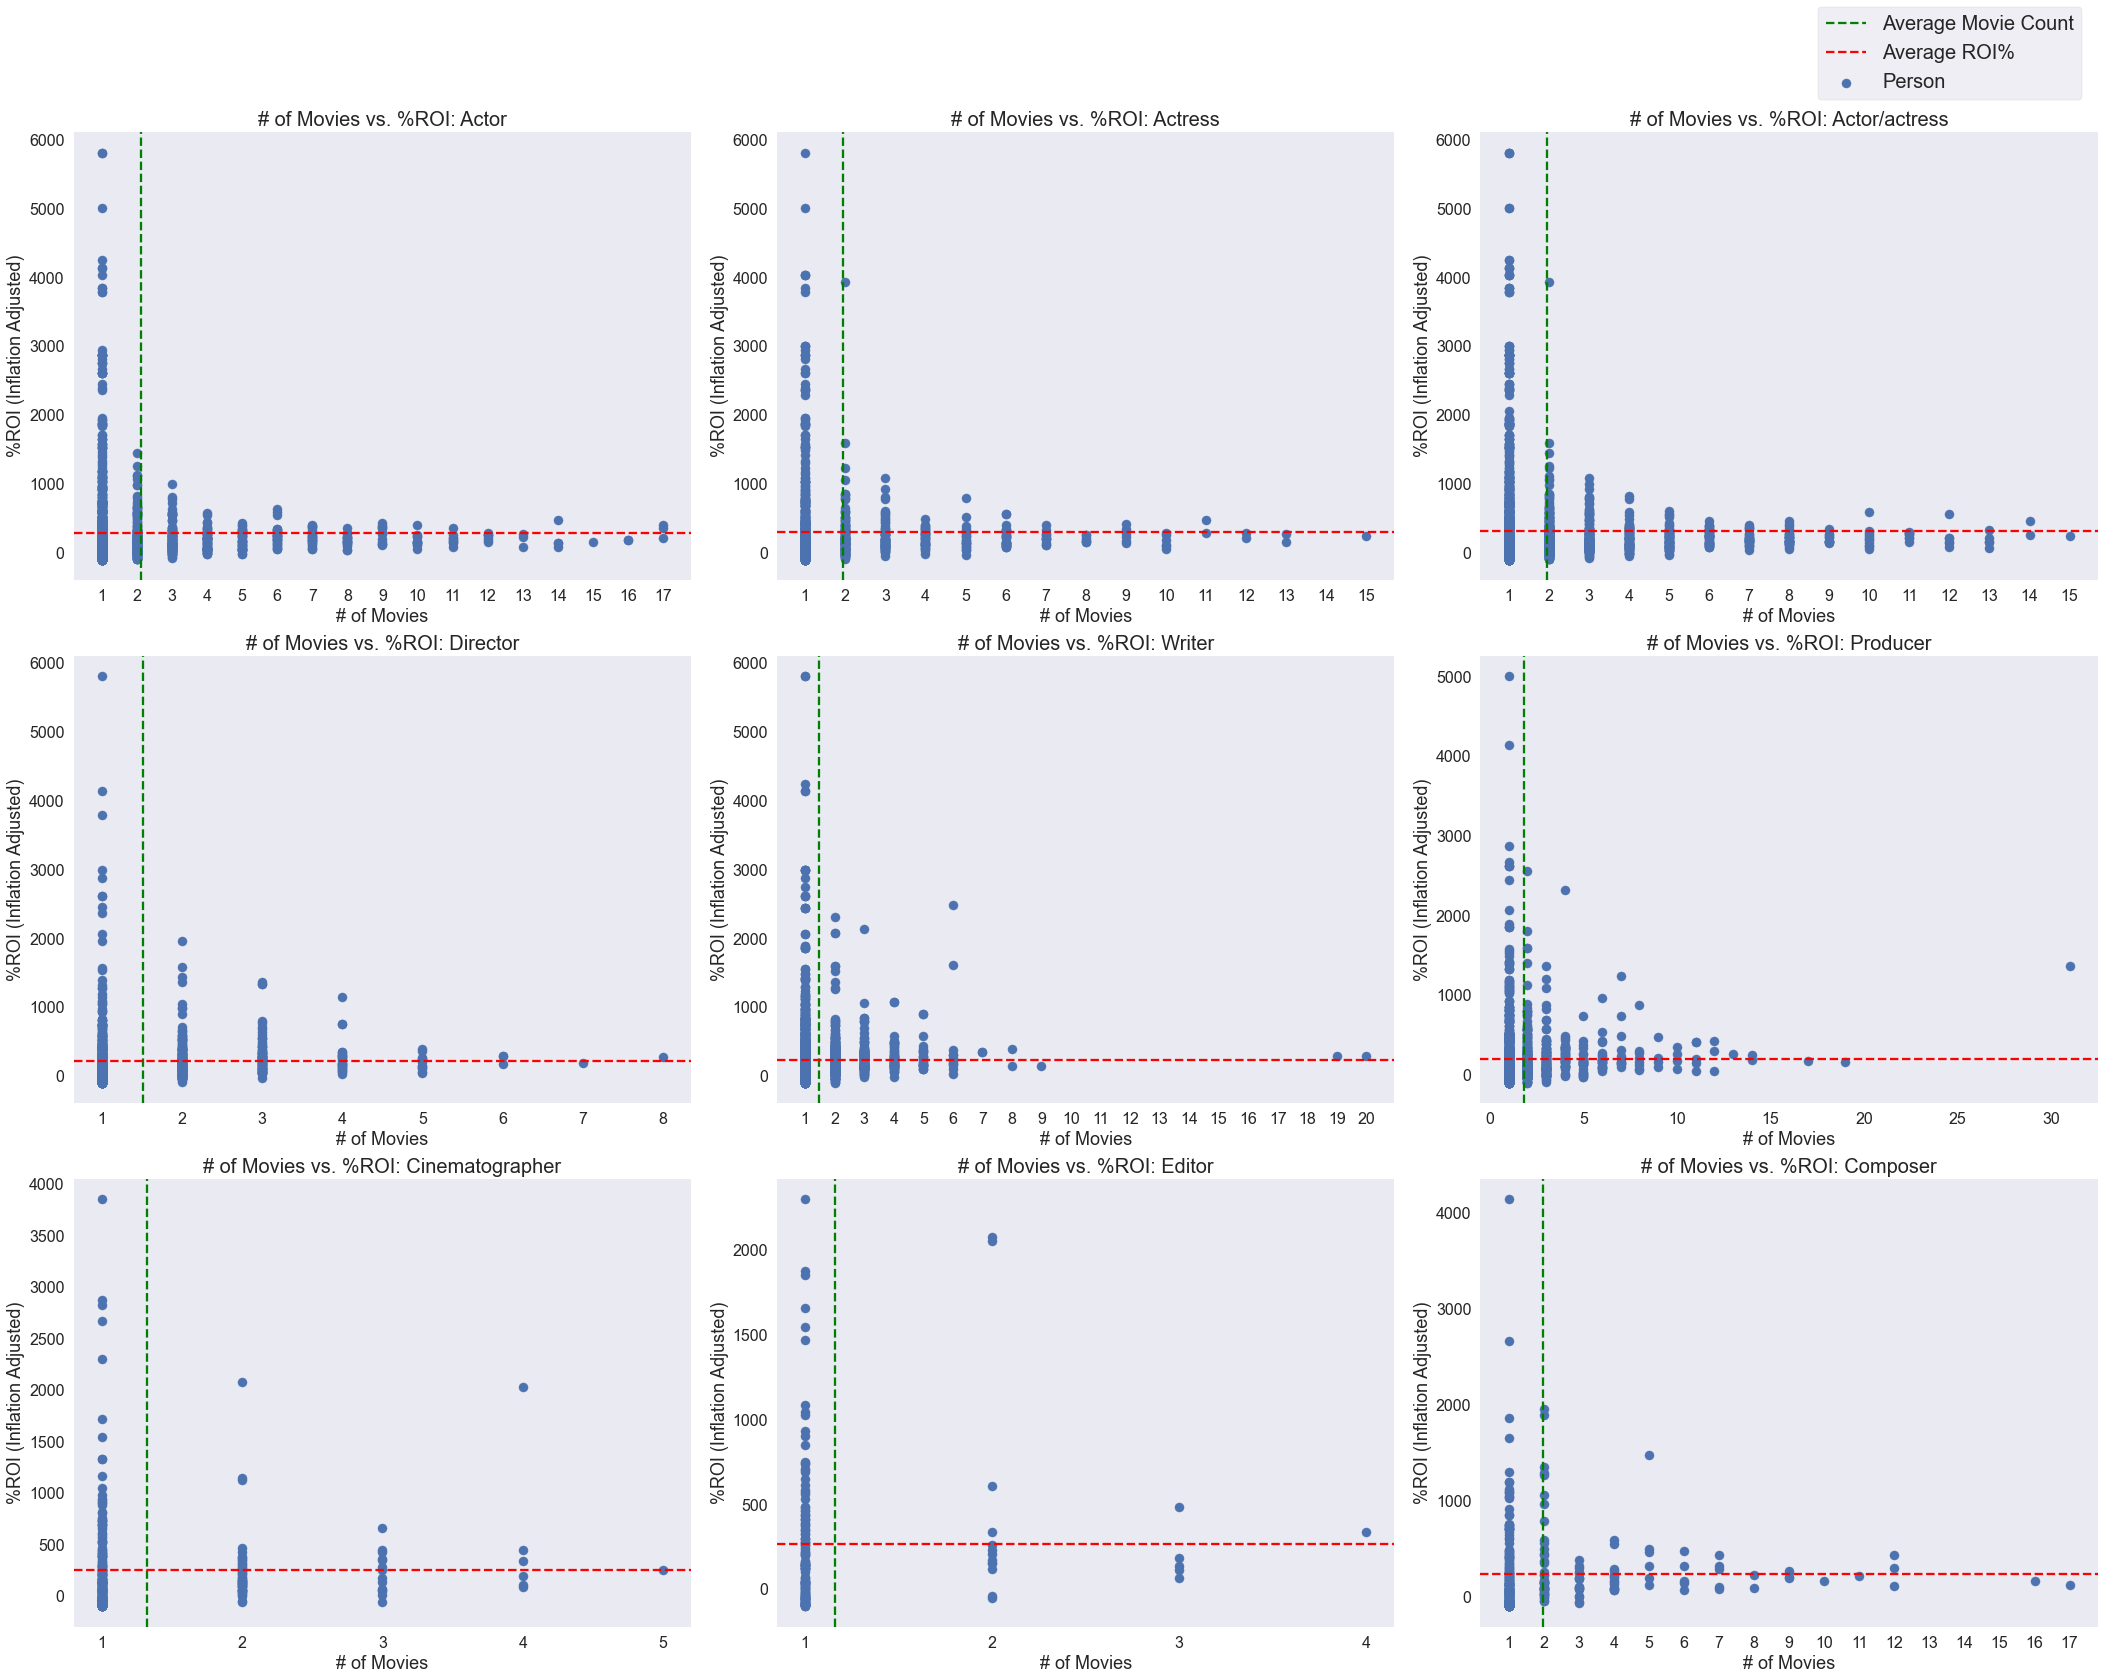

In [21]:
# all # of movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[30,22.5])
plt.tight_layout(pad=5)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp`
    # `movie_count` on x, `ROI_careertot%` on y
    ax[r,c].scatter(x=ppl_comp[ppl]['movie_count'],y=ppl_comp[ppl]['ROI_careertot%'], label='Person')
    
    # plot averages in `ppl_comp_avgs`
    # `f'{ppl}_movie_count'` vertical line
    # `f'{ppl}_%ROI_avg'` horizontal line
    ax[r,c].axvline(ppl_comp_avgs[f'{ppl}_movie_count'], ls='--', color='green', label='Average Movie Count')
    ax[r,c].axhline(ppl_comp_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # labels and title
    ax[r,c].set_xlabel('# of Movies', fontsize=18)
    ax[r,c].set_ylabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'# of Movies vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
    # set ticks in increments of 1, except 'producer', which is 5 due to high movie counts
    if ppl == 'producer':
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(5))
    else:
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(1))

# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.97,0.98), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('movie_roi_scatter_allmov.png')

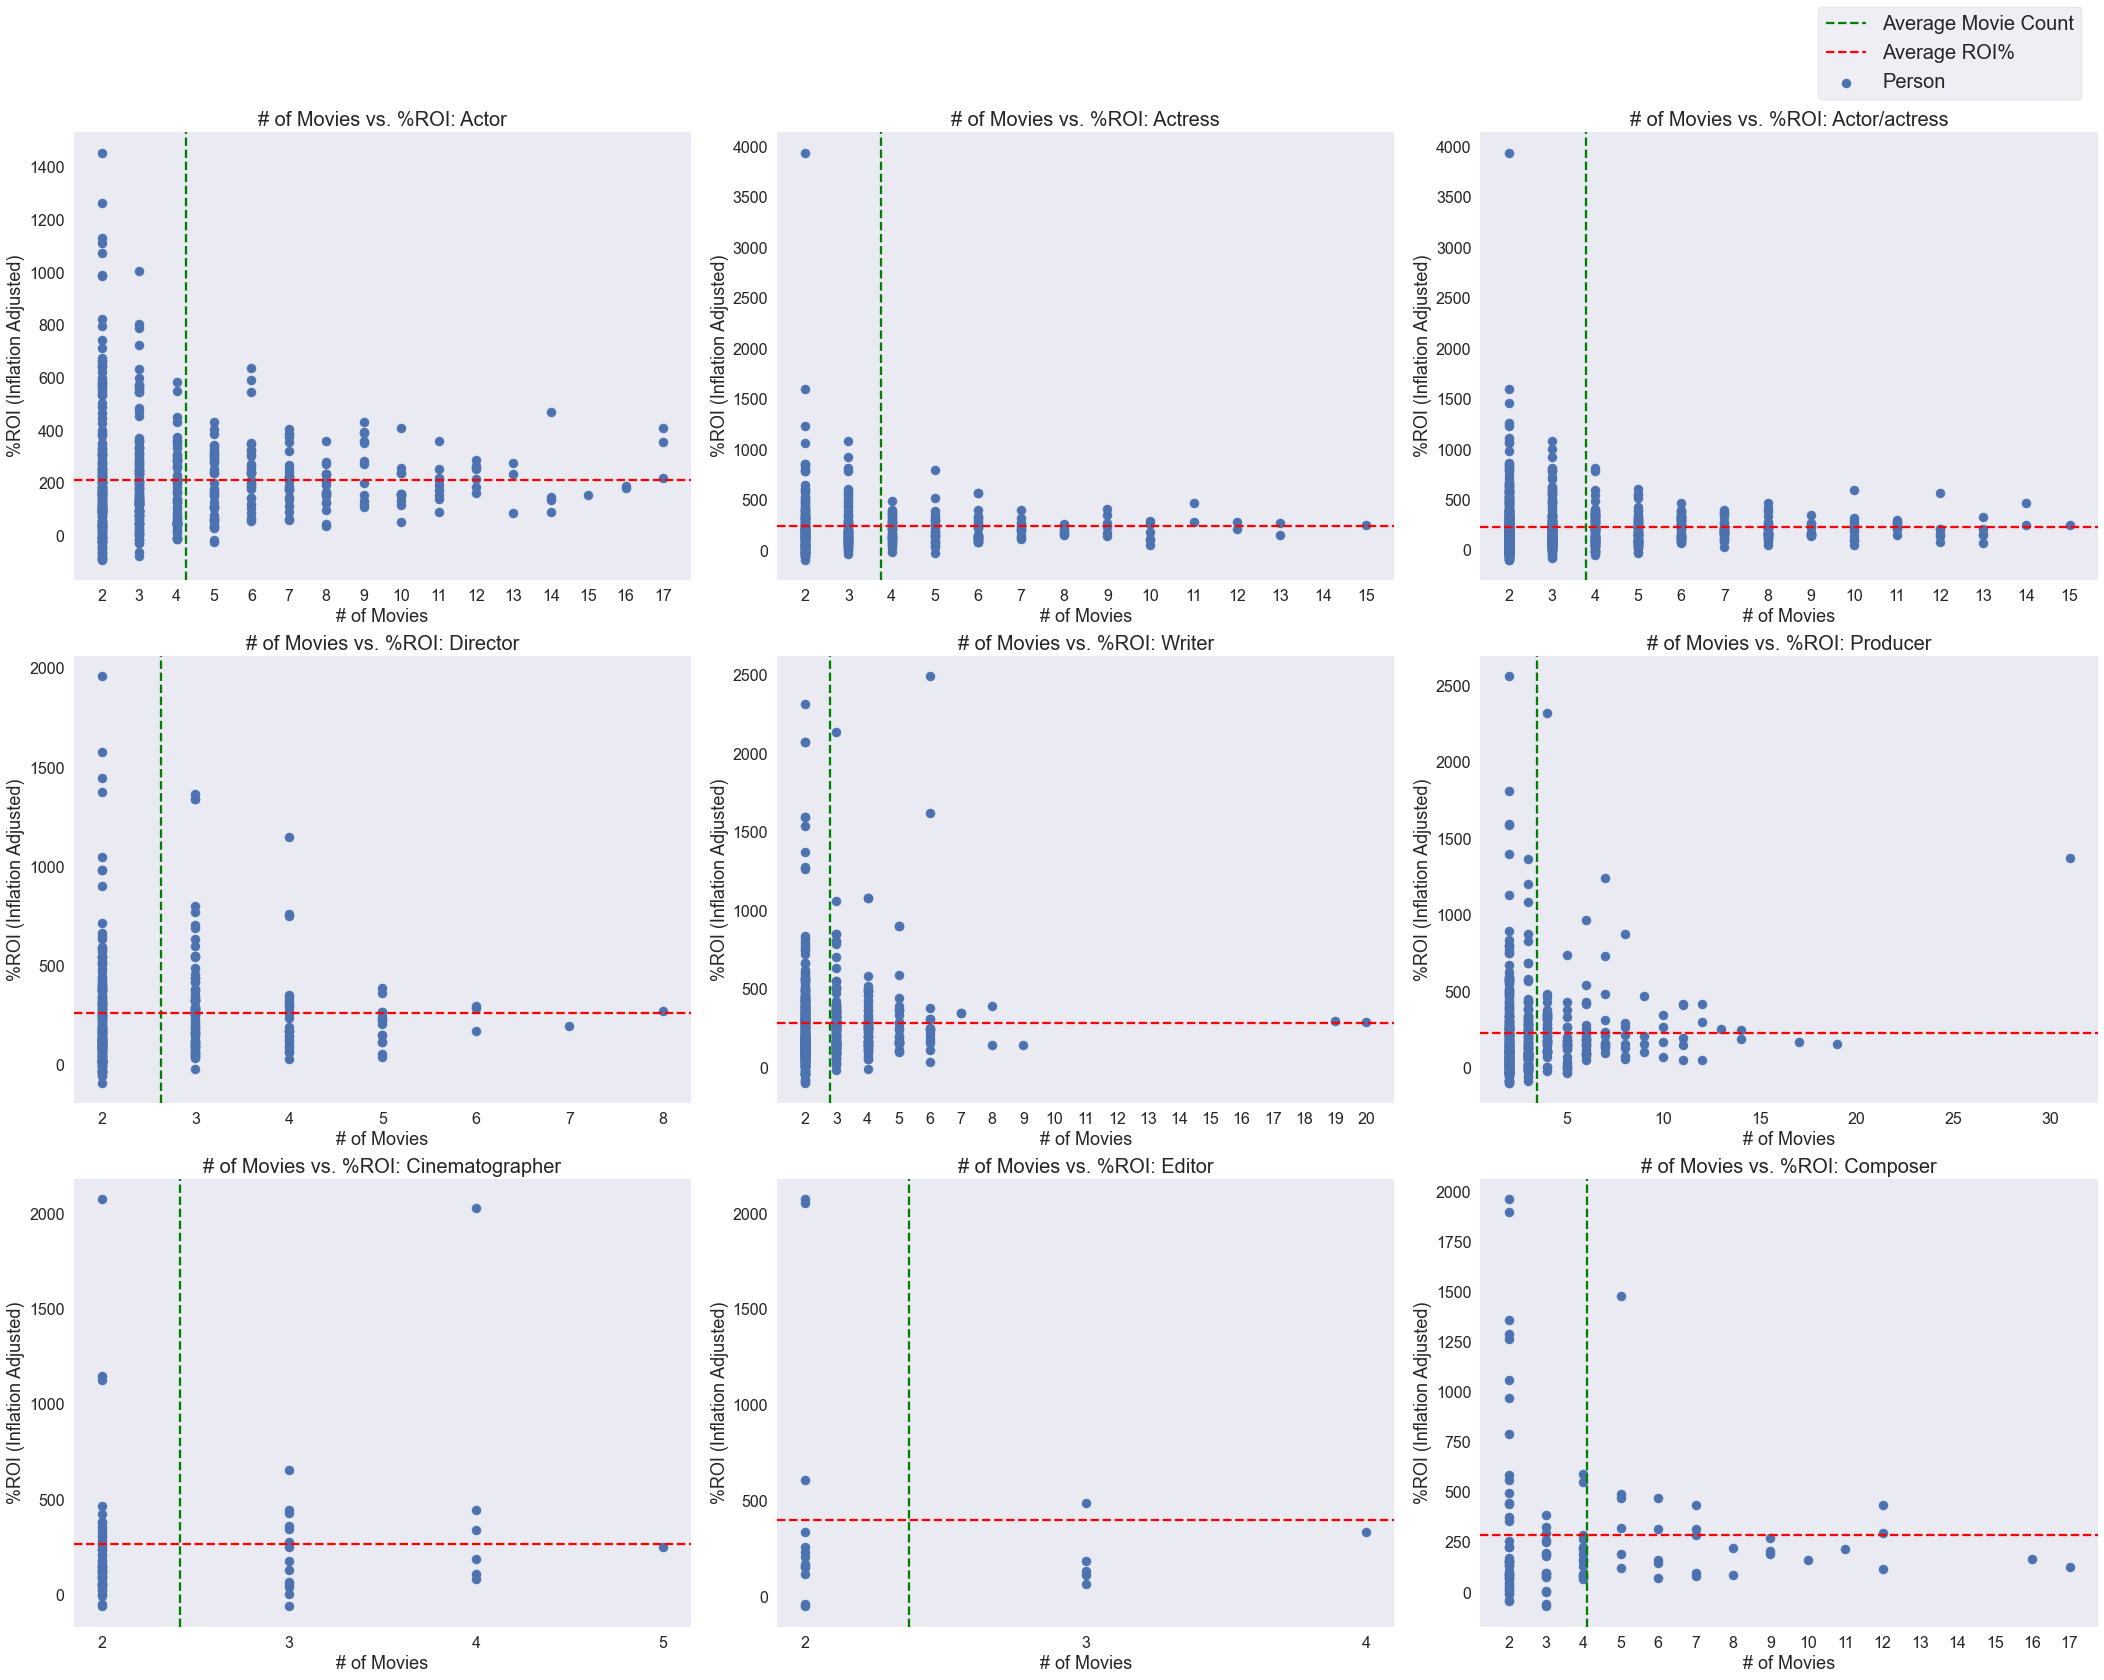

In [22]:
# at least 2 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[30,22.5])
plt.tight_layout(pad=5)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp2`
    # `movie_count` on x, `ROI_careertot%` on y
    ax[r,c].scatter(x=ppl_comp2[ppl]['movie_count'],y=ppl_comp2[ppl]['ROI_careertot%'], label='Person')
    
    # plot averages in `ppl_comp2_avgs`
    # `f'{ppl}_movie_count'` vertical line
    # `f'{ppl}_%ROI_avg'` horizontal line
    ax[r,c].axvline(ppl_comp2_avgs[f'{ppl}_movie_count'], ls='--', color='green', label='Average Movie Count')
    ax[r,c].axhline(ppl_comp2_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # labels and title
    ax[r,c].set_xlabel('# of Movies', fontsize=18)
    ax[r,c].set_ylabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'# of Movies vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
    # set ticks in increments of 1, except 'producer', which is 5 due to high movie counts
    if ppl == 'producer':
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(5))
    else:
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(1))

# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.97,0.98), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('movie_roi_scatter_2plusmov.png')

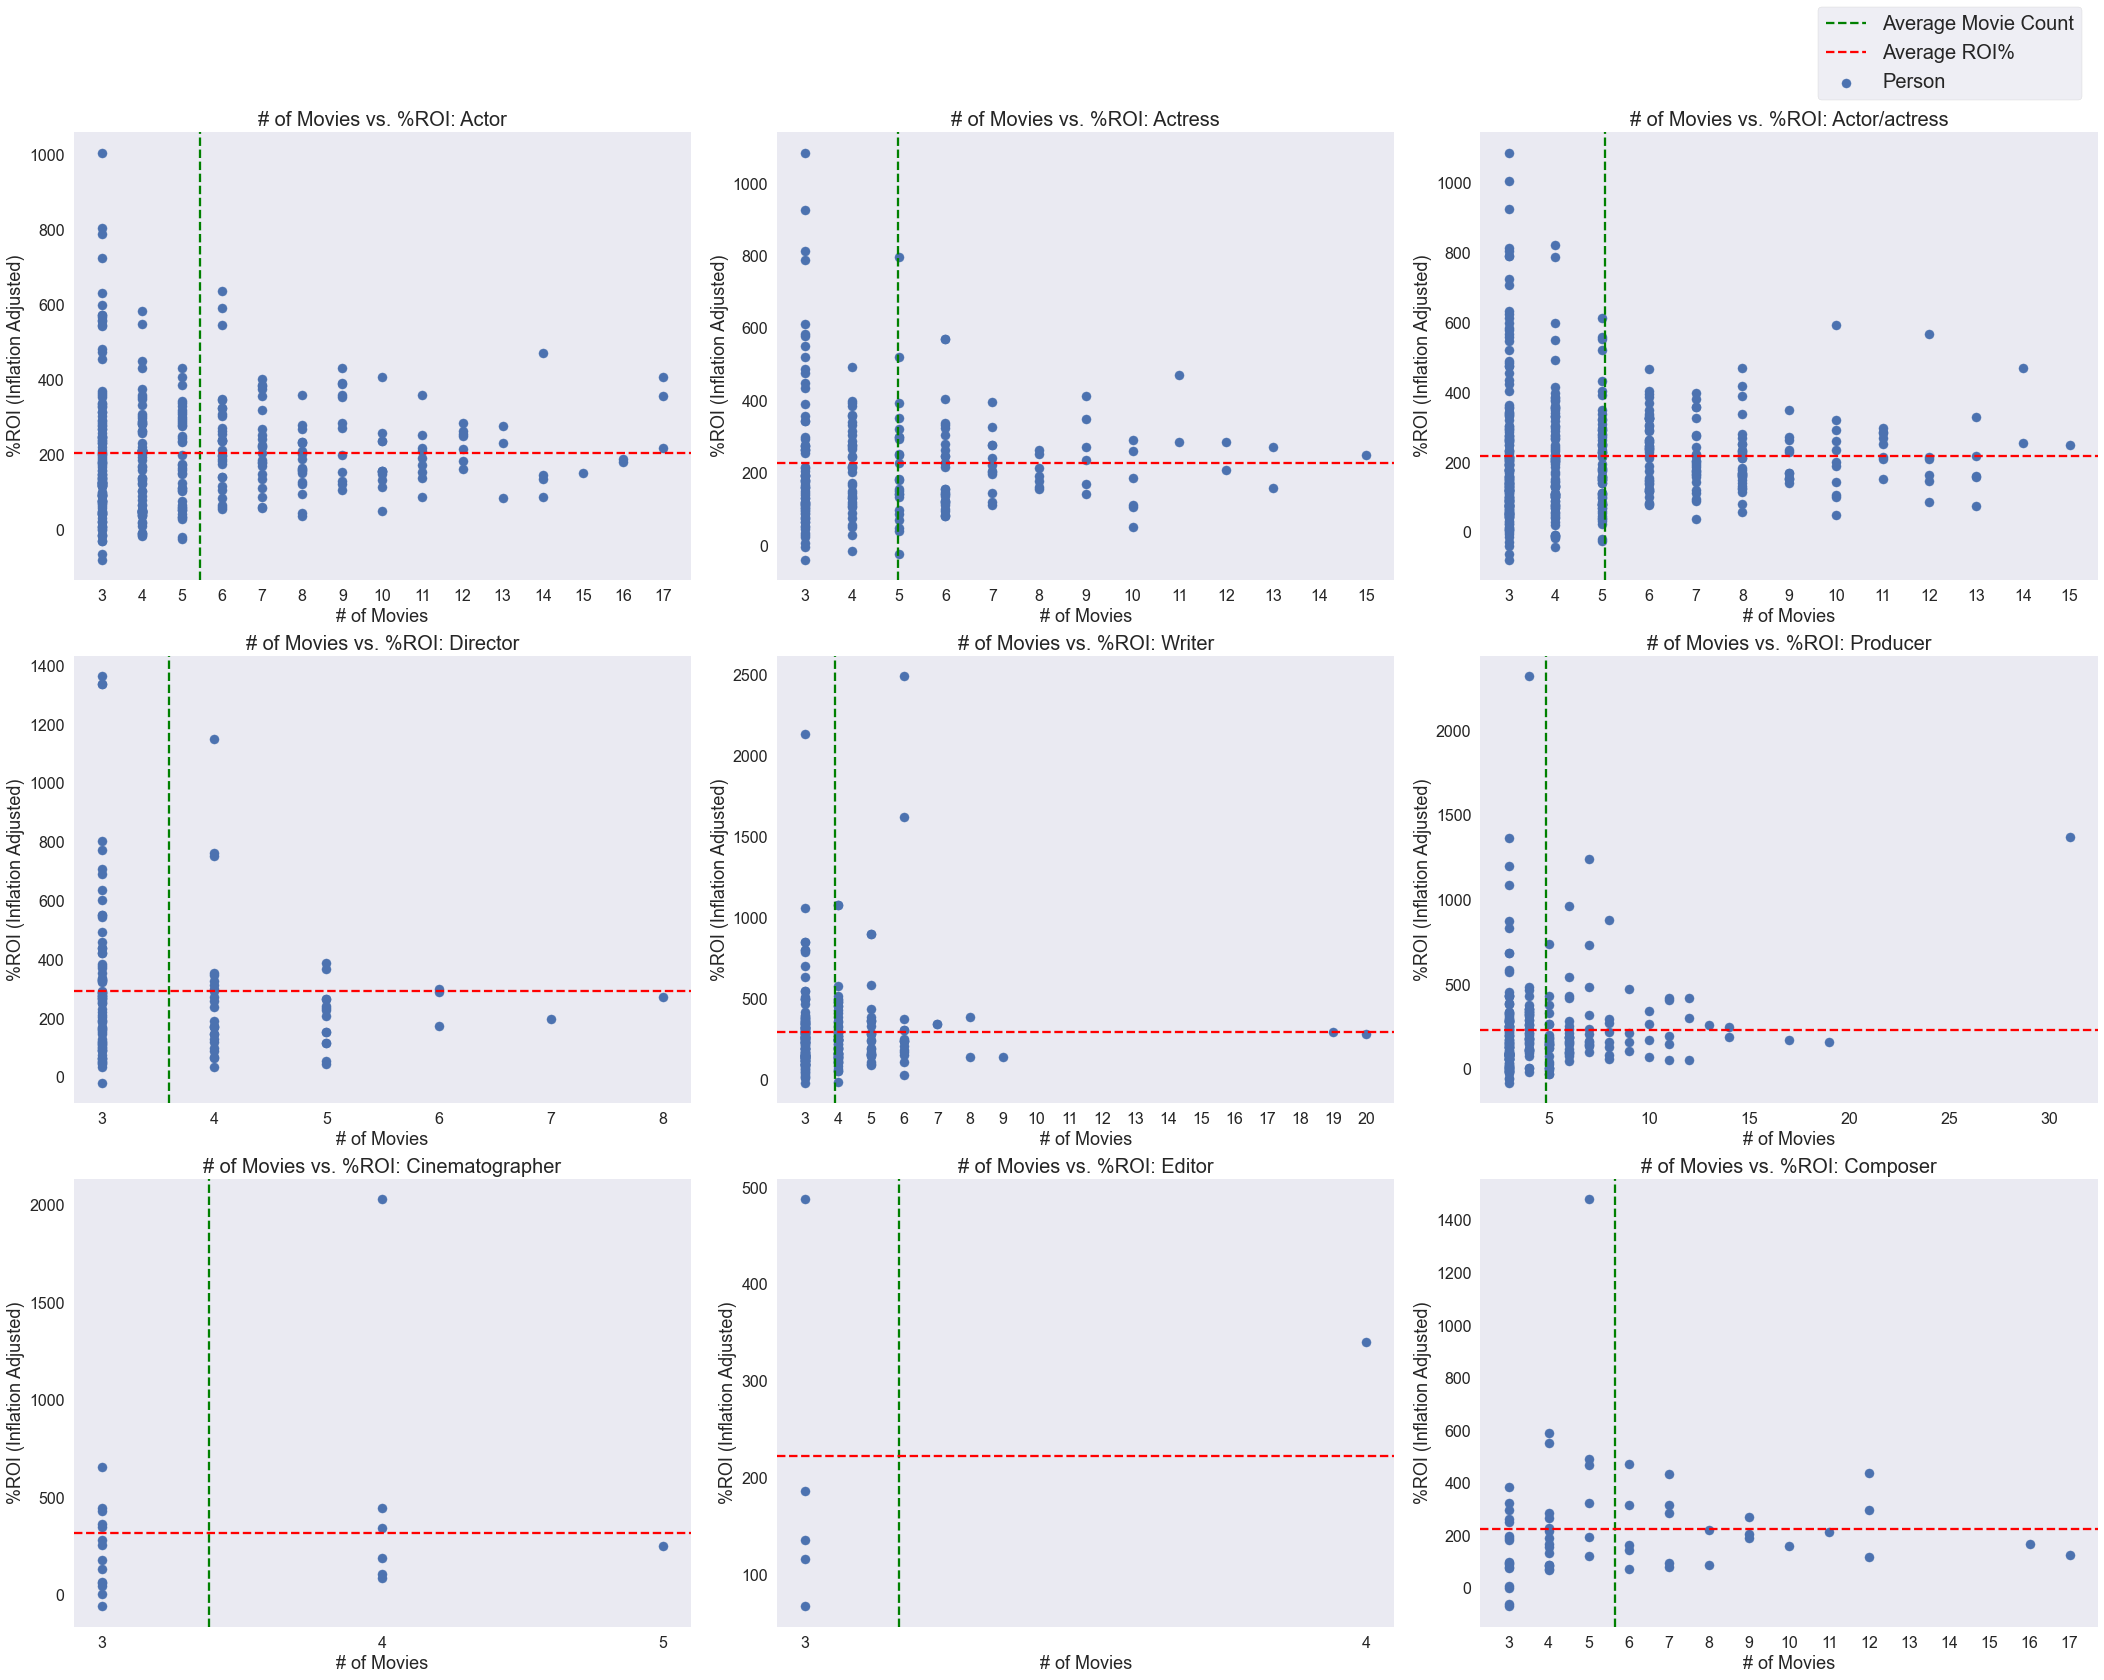

In [23]:
# at least 3 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[30,22.5])
plt.tight_layout(pad=5)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp3`
    # `movie_count` on x, `ROI_careertot%` on y
    ax[r,c].scatter(x=ppl_comp3[ppl]['movie_count'],y=ppl_comp3[ppl]['ROI_careertot%'], label='Person')
    
    # plot averages in `ppl_comp3_avgs`
    # `f'{ppl}_movie_count'` vertical line
    # `f'{ppl}_%ROI_avg'` horizontal line
    ax[r,c].axvline(ppl_comp3_avgs[f'{ppl}_movie_count'], ls='--', color='green', label='Average Movie Count')
    ax[r,c].axhline(ppl_comp3_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # labels and title
    ax[r,c].set_xlabel('# of Movies', fontsize=18)
    ax[r,c].set_ylabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'# of Movies vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
    # set ticks in increments of 1, except 'producer', which is 5 due to high movie counts
    if ppl == 'producer':
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(5))
    else:
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(1))

# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.97,0.98), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('movie_roi_scatter_3plusmov.png')

## Step 7: Plot top performers in each role in a bar graph

Now we can hone in on the 5 best people in each role and compare them on one axis: ROI%

In [24]:
# grab top 5 names in each position, for the three movie number cutoffs
ppl_compT = {}
ppl_comp2T = {}
ppl_comp3T = {}

for ppl in ppl_comp.keys():
    ppl_compT[ppl] = ppl_comp[ppl].head(5)

for ppl in ppl_comp2.keys():
    ppl_comp2T[ppl] = ppl_comp2[ppl].head(5)

for ppl in ppl_comp3.keys():
    ppl_comp3T[ppl] = ppl_comp3[ppl].head(5)

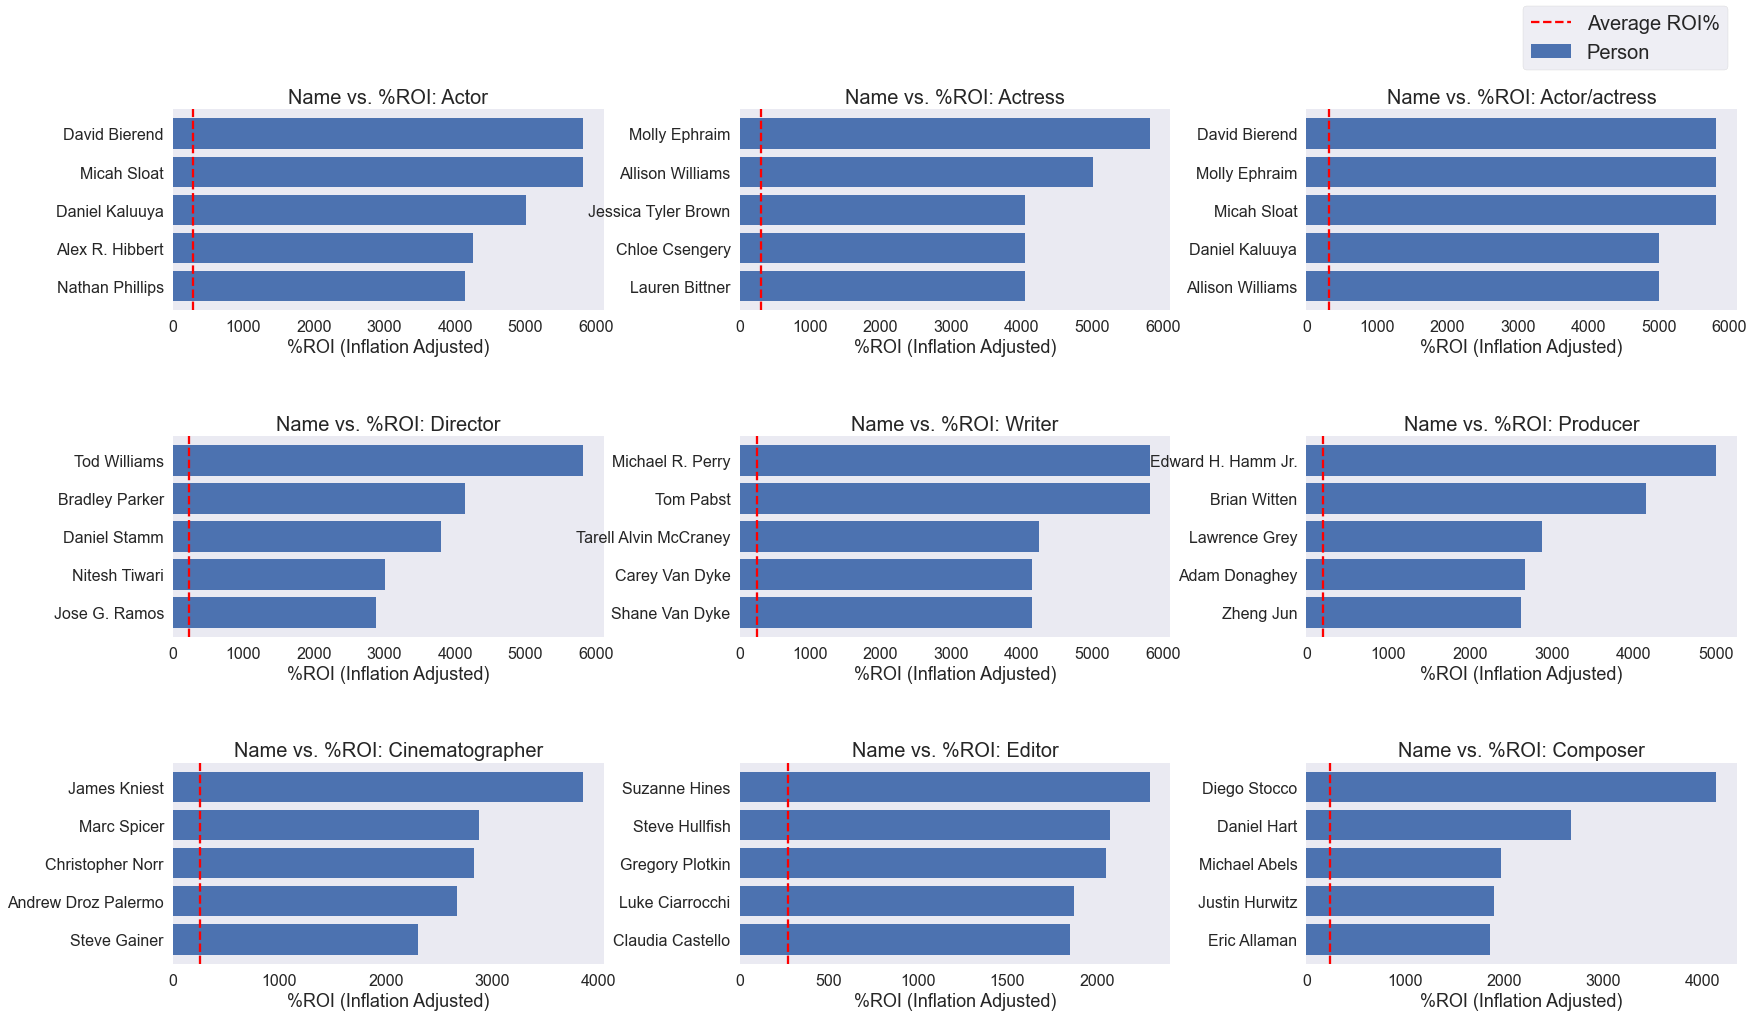

In [25]:
# all # of movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[25,15])
plt.tight_layout(pad=10)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_compT`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_compT[ppl]['primary_name'],width=ppl_compT[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp_avgs`
    ax[r,c].axvline(ppl_comp_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.94,0.93), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('name_roi_bar_allmov.png');

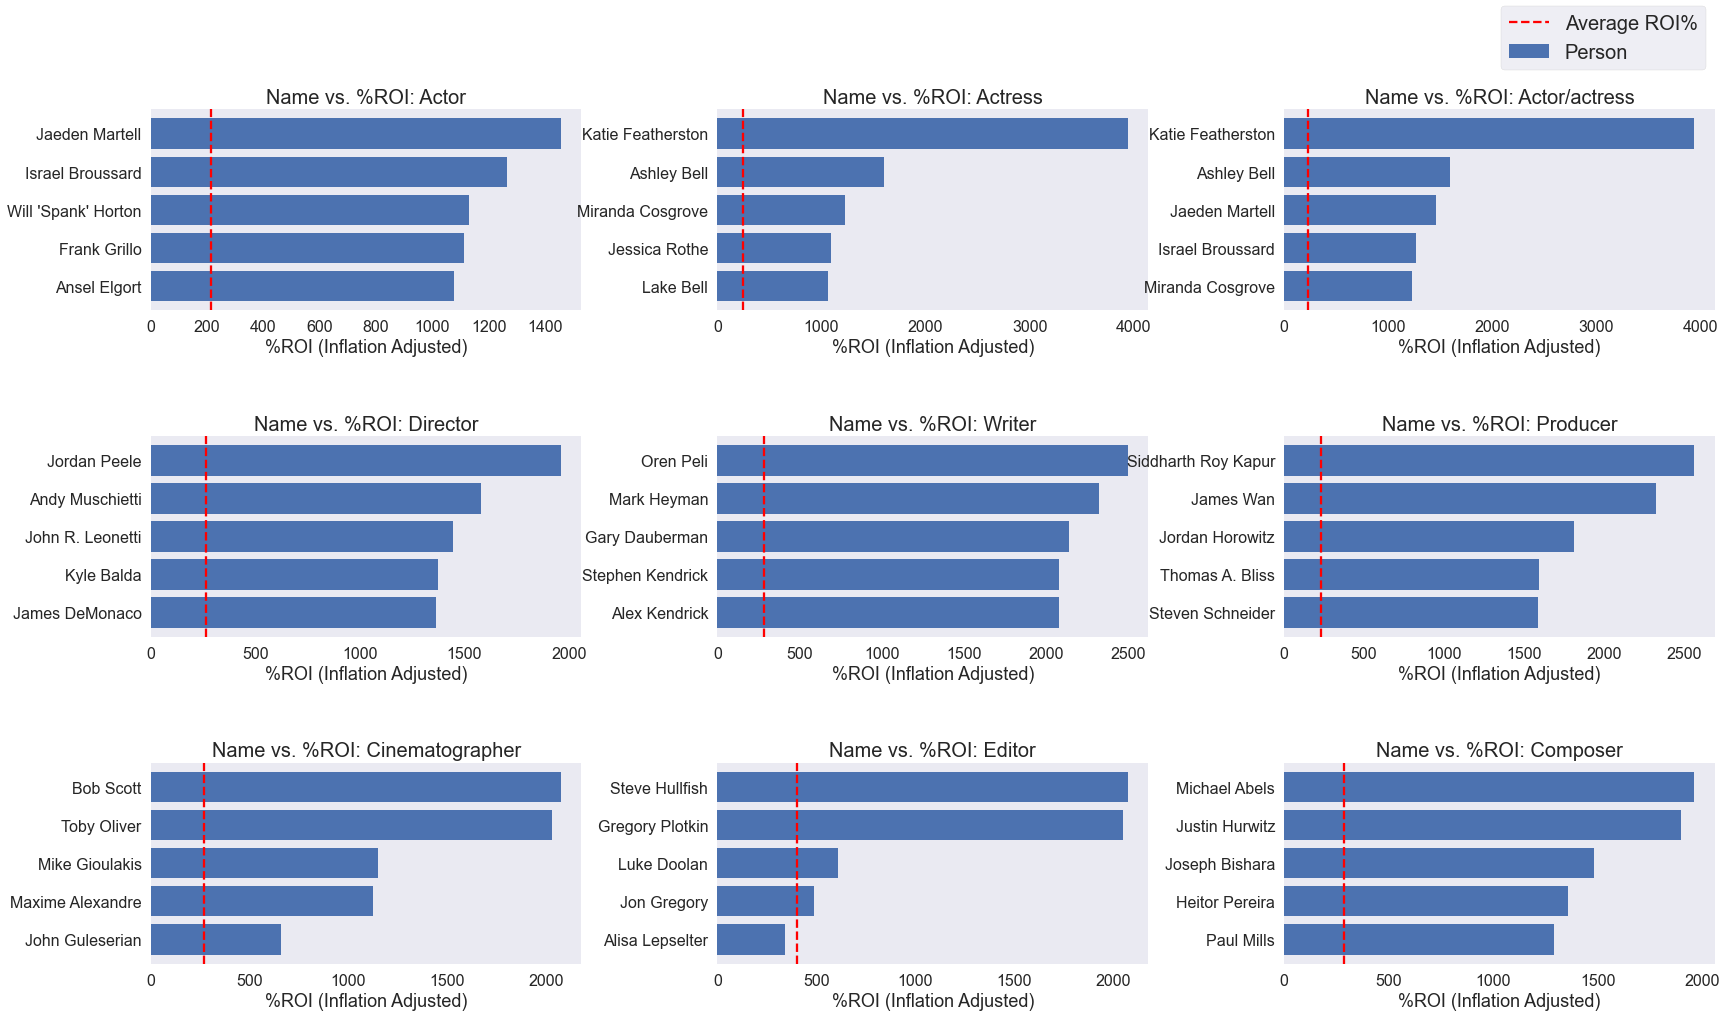

In [26]:
# at least 2 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[25,15])
plt.tight_layout(pad=10)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp2T`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_comp2T[ppl]['primary_name'],width=ppl_comp2T[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp2_avgs`
    ax[r,c].axvline(ppl_comp2_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.94,0.93), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('name_roi_bar_2plusmov.png')

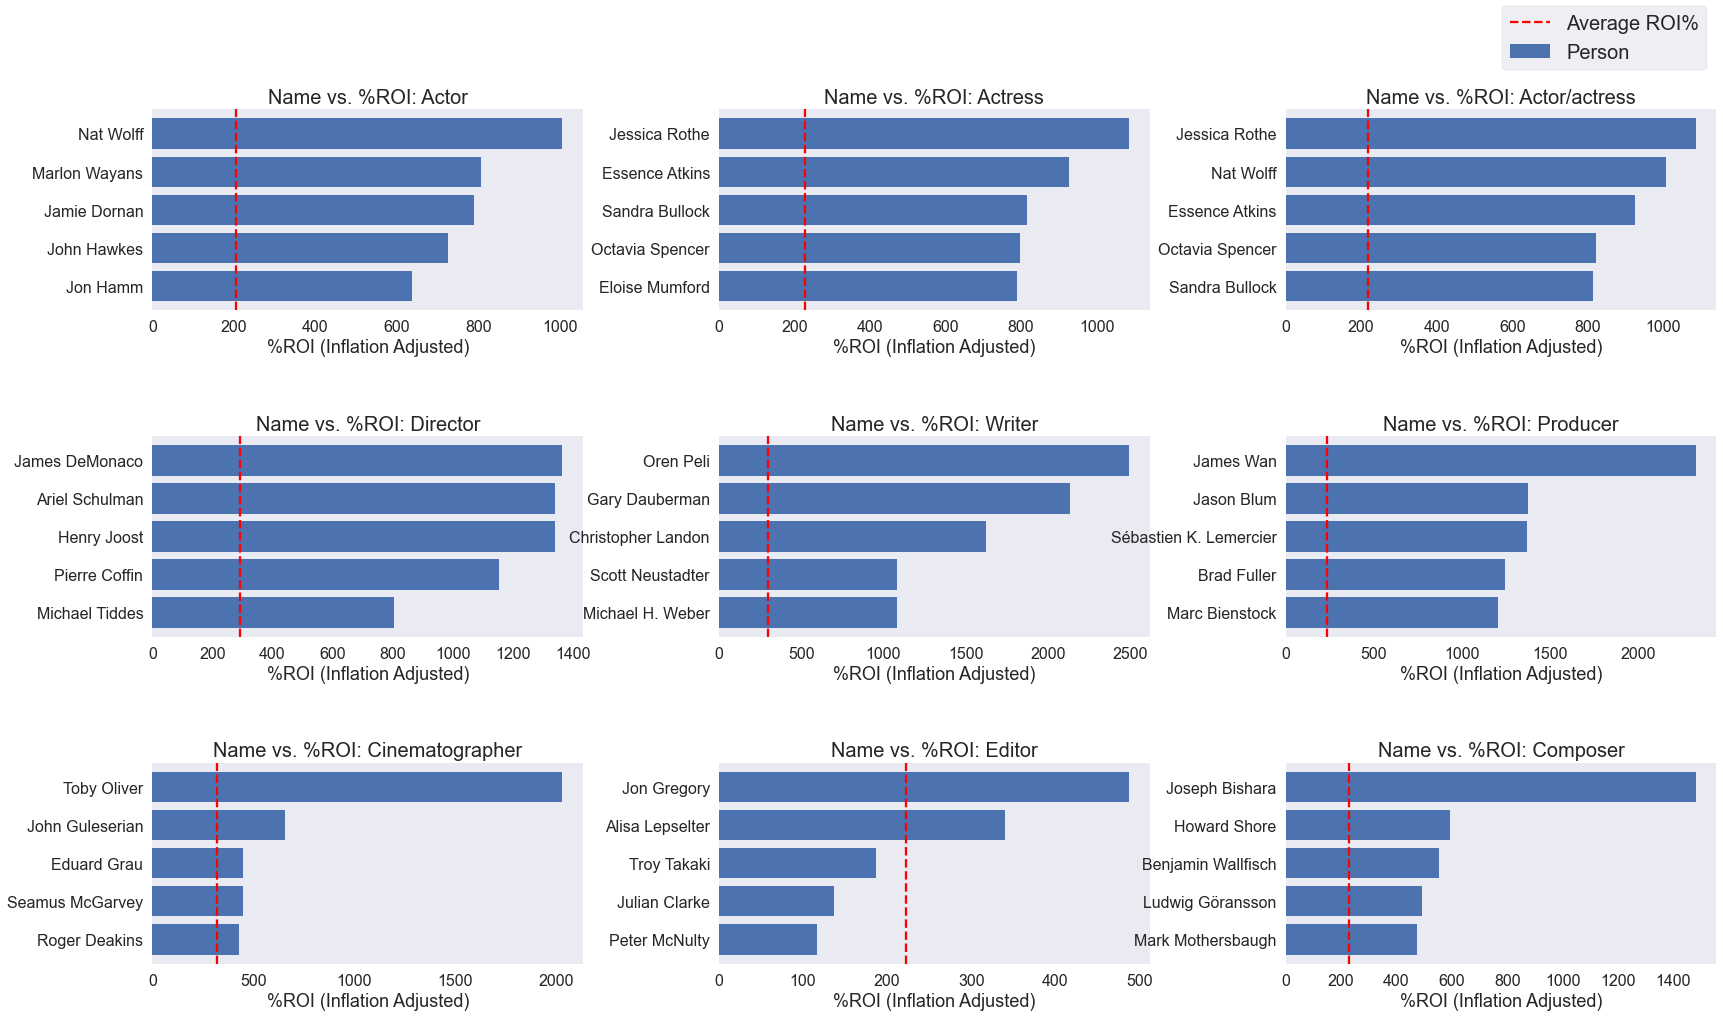

In [27]:
# at least 3 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[25,15])
plt.tight_layout(pad=10)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp3T`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_comp3T[ppl]['primary_name'],width=ppl_comp3T[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp2_avgs`
    ax[r,c].axvline(ppl_comp3_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.94,0.93), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('name_roi_bar_3plusmov.png')

## Step 8: Select the standouts of all roles

For at least 2 movies made, the standouts are in actor/actress, director, producer, and editor roles.

Standouts means that their ROI% is significantly greater than the other people close to them in that role.

In [ ]:
finalppl = ['actor/actress','director','producer','editor']

In [ ]:
# create figure
fig, ax = plt.subplots(2, 2, figsize=[28,16])
plt.tight_layout(pad=10)
# get index `i` for plotting purposes, `ppl` for dataframe data purposes
# from the list of `ppl` keys in `finalppl`
for i,ppl in enumerate(finalppl):
    
    # to orient the figure in the correct subplot
    r = i//2
    c = i%2
    
    # plot the data in `ppl` dataframes from `ppl_comp2T`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_comp2T[ppl]['primary_name'],width=ppl_comp2T[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp2_avgs`
    ax[r,c].axvline(ppl_comp2_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.93,0.92), loc='lower right', fontsize=20, frameon=True)
plt.savefig('images/peoplefigs/finalppl_2plus.png');

## Rating and twitter review analysis

## Grouping functions

Functions defined below are used to create categorical variables.

In [ ]:
# Define various thresholds for bucketing and categorical variables

budget_threshold = 0
start_year = 2010
low_budget_max = 5000000
mid_budget_max = 50000000
low_review_max = 7
low_vote_count = 500
year_cutoff = 2016

In [ ]:
# Define functions used to group data

# Function for calculating weighted average of two columns in a dataframe
def w_avg(df, value, weight):
    v = df[value]
    w = df[weight]
    
    return ((v*w).sum() / (w).sum())

# Create a function to define budget tiers
def budget_tiers(num):
    if num < low_budget_max:
        return 'Low Budget'
    elif num < mid_budget_max:
        return 'Medium Budget'
    else:
        return 'High Budget'

# Function to define what is a high or low review    
def review_tiers(num):
    if num <= low_review_max:
        return 'Low Review'
    else:
        return 'High Review'
    
# Define tiers of vote counts
def vote_count_tiers(num):
    if num <= low_vote_count:
        return 'Low Count'
    else:
        return 'High Count'
    
# Flag horror / thriller movies
def is_horror_thriller(_list):
    if 'Horror' in _list:
        return True
    elif 'Thriller' in _list:
        return True
    
# Group the years into two buckets
def group_year(num):
    if num <= year_cutoff:
        return 'Pre 2017'
    else:
        return '2017+'

## Data Prep

- Read in CSV files
- Perform final data cleaning
- Create categorical variables based on the above functions

In [ ]:
# plt.style.available
plt.style.use('seaborn')

In [ ]:
# Read in CSV files
imdb = pd.read_csv('cleanData/imdb_combined_prof.csv')
tn_df = pd.read_csv('cleanData/theNumbers_clean.csv')
twitter_reviews = pd.read_csv('cleanData/twitter_reviews_clean.csv')

In [ ]:
# Rename ROI % in the file

imdb.rename(columns={'ROI %': 'ROI_percent'}, inplace=True)

In [ ]:
# Make sure data if filtered for 2000 and later (should be taken care of in data cleaning section)

imdb = imdb[imdb['start_year'] >= start_year]
tn_df = tn_df[tn_df['year'] >= start_year]
twitter_reviews = twitter_reviews[twitter_reviews['year'] >= start_year]

# Drop duplicates in twitter reviews so we can concatenate on name
twitter_reviews.drop_duplicates(subset=['name'], inplace=True)

# Create concatenated columns for join
twitter_reviews['concat'] = twitter_reviews['name'] + twitter_reviews['year'].apply(lambda x: str(x))

# Merge datasets
twitter_prof = twitter_reviews.merge(tn_df, how='inner', left_on='name', right_on='movie')
imdb_total = imdb.merge(twitter_reviews, how='inner', on='concat')

# Filter for movies with above the specified production budget
imdb_total_f = imdb_total[imdb_total['production_budget_inf'] >= budget_threshold]
twitter_prof_f = twitter_prof[twitter_prof['production_budget_inf'] >= budget_threshold]

# Rename twitter rating columns
imdb_total_f.rename(columns={'avg_rating': 'twitter_avg_rating', 'rating_count': 'twitter_rating_count'}, inplace=True)

In [ ]:
# Create categorical variables

# Create a new column with budget tiers as categorical
imdb_total_f['budget_tier'] = imdb_total_f['production_budget_inf'].apply(budget_tiers)
twitter_prof_f['budget_tier'] = twitter_prof_f['production_budget_inf'].apply(budget_tiers)

# Create a new column with review tiers as categorical
imdb_total_f['review_tier_IMDB'] = imdb_total_f['averagerating'].apply(review_tiers)
imdb_total_f['review_tier_twitter'] = imdb_total_f['twitter_avg_rating'].apply(review_tiers)

# Create categorical variables for vote count tiers
imdb_total_f['count_tier_IMDB'] = imdb_total_f['numvotes'].apply(vote_count_tiers)
imdb_total_f['count_tier_twitter'] = imdb_total_f['twitter_rating_count'].apply(vote_count_tiers)

# Create column for year categoricals
imdb_total_f['year_count'] = imdb_total_f['start_year'].apply(group_year)

In [ ]:
# Scale ROI so that it can be described as %

imdb_total_f['ROI_percent'] = imdb_total_f['ROI_percent'] * 100

# Remove random duplicate columns that were created
imdb_total_f.drop(columns=['Unnamed: 0_x'], axis=1, inplace=True)
imdb_total_f.drop(columns=['Unnamed: 0_y'], axis=1, inplace=True)

In [ ]:
# Clean up one NA nad convert genres to list type

imdb_total_f.dropna(subset=['genres'], inplace=True)
imdb_total_f.loc[:,'genres'] = imdb_total_f.loc[:,'genres'].apply(literal_eval)

## Analysis 1: ROI vs. Average Review

Summary: the hypothesis was that the higher rated movies would do better at the box office.

Analysis: Movings were grouped by rating. Any movie that received an 8 or higher was considered a "good" review. This may seem high, but the average review for the population was over 7. I also looked at the horror / thriller only population to see if the effect was visible there.

Result: there does seem to be a meaningful relationship between good reviews and sales. These movies do much better than the population average. The effect is even more pronounced for horror / thriller movies.

In [ ]:
# Find the total population average

wavg = ((imdb_total_f['worldwide_gross_inf'].sum() - imdb_total_f['production_budget_inf'].sum()) /
        imdb_total_f['production_budget_inf'].sum())

In [ ]:
# Group data by IMDB review tier: Good or bad

IMDB_tier = pd.DataFrame(imdb_total_f.groupby('review_tier_IMDB').sum())
IMDB_tier['ROI_new'] = (IMDB_tier['worldwide_gross_inf'] - IMDB_tier['production_budget_inf']) / IMDB_tier['production_budget_inf']

In [ ]:
# Filter out only horror and thriller movies

imdb_total_f['horror_thriller'] = imdb_total_f['genres'].apply(is_horror_thriller)
imdb_horror = imdb_total_f[imdb_total_f['horror_thriller'] == True]

horror_review_tier = pd.DataFrame(imdb_horror.groupby('review_tier_IMDB').sum())

horror_review_tier['ROI_new'] = ((horror_review_tier['worldwide_gross_inf'] - horror_review_tier['production_budget_inf']) 
                                / horror_review_tier['production_budget_inf'])

In [ ]:
# Combine total and horror review datasets

total_review_tier = IMDB_tier.merge(horror_review_tier, how='inner', left_index=True, right_index=True)
total_review_tier = total_review_tier.loc[:,['ROI_new_x', 'ROI_new_y']]
total_review_tier = total_review_tier.rename(columns={'ROI_new_x': 'ROI_Total', 'ROI_new_y': 'ROI_Horror'})

In [ ]:
# Calculate combined reviews

fig, ax = plt.subplots(figsize=(6,4))

labels = ['Total Reviews', 'Horror / Thriller Only']
x = np.arange(len(labels))
width = 0.25

bars1 = total_review_tier.iloc[0,:]
bars2 = total_review_tier.iloc[1,:]

ax.bar(x - width/2, bars1, width, label='Good Reviews')
ax.bar(x + width/2, bars2, width, label='Poor Reviews')

ax.set_ylabel('ROI %', fontsize=12)
# ax.set_title('ROI by Review Category', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)
ax.grid(False)

plt.axhline(y=wavg,linewidth=1, color='red', linestyle='--')

plt.savefig('./images/Review_vs_ROI.png')

plt.tight_layout();

In [ ]:
pickup_total = (total_review_tier.iloc[0,0] - total_review_tier.iloc[1,0]) / total_review_tier.iloc[1,0]
pickup_horror = (total_review_tier.iloc[0,1] - total_review_tier.iloc[1,1]) / total_review_tier.iloc[1,1]

print(pickup_total, pickup_horror)

## Analysis 2: ROI vs. Number of Twitter Reviews

Summary: the hypothesis is that number of reviews on Twitter, as a proxy for total social media engagement, would drive higher movie ROI
Analysis: The original dataset was grouped by year and vote count categoricals. I.e., before 2017 vs. after 2017 and high number of reviews vs. low number of reviews. The average ROI for these populations was recalculated.
Result: while there was a decent result for the overall population, what really stood out is that post 2017, twitter engagement really seems to matter - driving a 100%+ increase in ROI vs. movies that did not have high engagement.

In [ ]:
twitter_review_count = imdb_total_f.groupby(['year_count', 'count_tier_twitter']).sum()

twitter_review_count['ROI_new'] = ((twitter_review_count['worldwide_gross_inf'] - twitter_review_count['production_budget_inf']) 
                                / twitter_review_count['production_budget_inf'])

twitter_review_count = twitter_review_count['ROI_new']

In [ ]:
pickup_17_after = (twitter_review_count.iloc[0] - twitter_review_count.iloc[1]) / twitter_review_count.iloc[1]
pickup_17_before = (twitter_review_count.iloc[2] - twitter_review_count.iloc[3]) / twitter_review_count.iloc[3]

print(pickup_17_after, pickup_17_before)

In [ ]:
# Calculate combined review count tiers

fig, ax2 = plt.subplots(figsize=(6,4))

labels = ['2017+', 'Pre 2017']
x = np.arange(len(labels))
width = 0.25

bars1 = [twitter_review_count.iloc[0], twitter_review_count.iloc[2]]
bars2 = [twitter_review_count.iloc[1], twitter_review_count.iloc[3]]

ax2.bar(x - width/2, bars1, width, label='High Twitter Engagement')
ax2.bar(x + width/2, bars2, width, label='Low Twitter Engagement')

ax2.set_ylabel('ROI %', fontsize=12)
# ax2.set_title('ROI by Review Category', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(False)

plt.axhline(y=wavg,linewidth=1, color='red', linestyle='--')

plt.savefig('./images/twitter_engagement.png')

plt.tight_layout();